In [32]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

###### Helper functions to enable functionality on other metric calculations

# A function to find the distribution of the time gaps
def findGaps(messages):
    messageTimes = np.asarray([pd.Timestamp(message['time']).tz_convert('UTC') for message in messages])
    return messageTimes[1:] - messageTimes[:-1]

# returns a list of senders in a thread
def getSenders(messageCollection):
    return [message['sender'] for message in messageCollection]

# returns a list of recipients for a given message
def getSetOfRecipients(messageRecipientObject):
    return [recip['email'] for recip in messageRecipientObject['recipients']]

# returns a list of types of recipients of a message
def getTypesOfRecipients(messageRecipientObject):
    return [recip['type'] for recip in messageRecipientObject['recipients']]

# get set-based overviews of participant collections (senders and recievers). concatenates sender and the reciever for a single message
def getInvolvedSetsMerged(messageCollection):
    sendersRecip = [[message['sender']] + getSetOfRecipients(message) for message in messageCollection]
    return np.asarray(sendersRecip)

# get set-based overviews of participant collections (senders and recievers). Leaves sender and the reciever in separate lists
def getInvolvedSetsSeperate(messageCollection):
    sendersRecip = [[[message['sender']], getSetOfRecipients(message)] for message in messageCollection]
    return np.asarray(sendersRecip)
###################################


####### Intermediate Research Functions that are used to investigate alternative measures
####### One can use these to create further measures

# research function to estimate proxies for pace of interaction for threads
def estimatePaceOfInteractionForThreadCollection(threadCollection):
    threadGaps = []
    # This is a measure to use as a proxy for the pace of interaction
    paceofInteraction_v1 = []
    for index, row in threadCollection.iterrows():
        gapsWithinAThread = findGaps(row["messages"])
        paceofInteraction_v1.append(np.median(gapsWithinAThread).total_seconds())
        # print ("Median Gap: ", medianGap.total_seconds() )
        threadGaps.append(gapsWithinAThread)
    # alternatively, this can return the threadGaps to come up with alternative proxies to paceOfInteraction
    # Another alternative, just the average
    # paceofInteraction_v2 = [np.sum(gapArray) / len(gapArray) for gapArray in threadGaps]
    return paceofInteraction_v1

# A testbed function to test for alternative diversity measures
def findSenderDiversity_v1(threadCollection):
    senderDiversity_v1 = []
    for index, row in threadCollection.iterrows():
        uniqueSenders, messageCounts = np.unique(getSenders(row["messages"]), return_counts=True)
        ent = scipy.stats.entropy(messageCounts)
        skew = scipy.stats.skew(messageCounts)
        iqr = scipy.stats.iqr(messageCounts/float(len(row["messages"])))
        print("Thread: ", index, " length: ", len(row["messages"]), " , with unique senders: ", len(uniqueSenders), " with diversity: ", len(uniqueSenders)/len(row["messages"]), " and with counts: ", messageCounts, " Entropy: ", ent, " Skew: ", skew, " IQR: ", iqr)
        senderDiversity_v1.append(len(uniqueSenders)/len(row["messages"]))
    return senderDiversity_v1
###################################



##### The collection of functions that are used to estimate the various proxy measures ####

# Proxy Measure of a single Thread  for "Pace of Interaction", description: median of all time gaps between messages
def threadProxyMeasurePaceOfInteractionAvgGap(thread):
    return np.median(findGaps(thread["messages"])).total_seconds()

# Proxy Measure of a single Thread for "Sender Diversity", description: "unique senders / number of messages"
def threadProxyMeasureSenderDiversitySimple(thread):
    return len(np.unique(getSenders(thread["messages"]))) / len(thread["messages"])

# Proxy Measure for diversity within senders using Entropy as a measure"
def threadProxyMeasureSenderDiversityEntropy(thread):
    uniqueSenders, messageCounts = np.unique(getSenders(thread["messages"]), return_counts=True)
    return scipy.stats.entropy(messageCounts)

# Proxy Measure for diversity within senders comparing the size of the set of individuals in the begining and the end, a proxy for branching
def threadProxyMeasureParticipantGrowth(thread):
    individualSet = getInvolvedSetsMerged(thread["messages"])
    initialSetSize = len(individualSet[0])
    # the number of unique people involved at the end of the thread
    finalSetSize = len(np.unique(np.concatenate(individualSet)))
    return finalSetSize / initialSetSize

# Proxy Measure for diversity within senders comparing the size of the change in the size of the set of individuals over the thread, a proxy for branching
# deliberately not using set intersections as this might conflate/inflate certain kinds of communications, sticking to the simple size variation instead
def threadProxyMeasureParticipantSizeVariation(thread):
    individualSet = getInvolvedSetsMerged(thread["messages"])
    # get the size of the number of people involved at each message to create a distribution
    sizesOfIndividuals = [len(individualSet) for individualSet in individualSet]
    # for the moment, just estimate the standard deviation of the above distribution of sizes of sets
    return np.std(sizesOfIndividuals)

# Proxy Measure for the level of engagement from the participants of a thread: #active/#allInvolved, an engaged discussion vs. a large audience
def threadProxyMeasureEngagement(thread):
    individualSets = getInvolvedSetsSeperate(thread["messages"])
    allSenders = np.unique(np.concatenate(individualSets[:, 0]))
    allRecievers = np.unique(np.concatenate(individualSets[:, 1]))
    passiveParticipants = np.setdiff1d(allRecievers, allSenders)
    return len(allSenders) / (len(allSenders) + len(passiveParticipants))

# A dictionary to bind measure names to function names that calculate them
proxyToFunction = dict([
    ('SenderDiversity', 'threadProxyMeasureSenderDiversitySimple'),
    ('PaceOfInteractionAvgGap', 'threadProxyMeasurePaceOfInteractionAvgGap'),
    ('SenderDiversityEntropy', 'threadProxyMeasureSenderDiversityEntropy'),
    ('ParticipantGrowth', 'threadProxyMeasureParticipantGrowth'),
    ('ParticipantSizeVariation', 'threadProxyMeasureParticipantSizeVariation'),
    ('Engagement', 'threadProxyMeasureEngagement'),
    ])

def estimateThredProxiesFromThreadCollection(threadCollection, threadMeasures):

    threadProxies = []
    for index, row in threadCollection.iterrows():
        proxiesForThread = []

        #proxiesForThread.append(row['threadId'])

        for measureName in threadMeasures:
            proxiesForThread.append(globals()[proxyToFunction[measureName]](row))

        threadProxies.append(proxiesForThread)
    return np.asarray(threadProxies)

def apply2DMDS(dataObject):
    scaler = MinMaxScaler()
    scaler.fit(dataObject)
    scaledData = scaler.transform(dataObject)
    mds = manifold.MDS(2, max_iter=100, n_init=1)
    Y = mds.fit_transform(scaledData)
    sns.scatterplot(x = Y[:, 0], y = Y[:, 1])
    plt.show()
    return Y[:, 0], Y[:, 1]

def applyTSNE(dataObject):
    from sklearn.manifold import TSNE
    scaler = MinMaxScaler()
    scaler.fit(dataObject)
    scaledData = scaler.transform(dataObject)
    results_tsne = TSNE().fit_transform(scaledData)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    proxies = list(proxyToFunction)
    for i, prox in enumerate(proxies):
        plt.title(prox)
        sns_plot = sns.scatterplot(x = results_tsne[:, 0], y = results_tsne[:, 1], hue = np.sqrt(dataObject[:, i]))
        sns_plot.figure.savefig(prox + "_tSNE_"+ ".png")
        plt.show()
    return results_tsne[:, 0], results_tsne[:, 1]

def updateThreadObjectsWithMeasures(threadObjectDF, measureNames, proxyValues):

    for index, measureName in enumerate(measureNames):
        threadObjectDF[measureName] = proxyValues[:, index].astype(float)
    return threadObjectDF

def updateThreadObjectsWithMDSEmbeddingCoordinates(threadObjectDF, proxyValues):
    mdsX, mdsY = apply2DMDS(proxyValues)
    # revise the thread objects with the MDS coordinates
    threadObjectDF["mdsX"] = mdsX.astype(float)
    threadObjectDF["mdsY"] = mdsY.astype(float)
    return threadObjectDF

def updateThreadObjectsWithtSNEEmbeddingCoordinates(threadObjectDF, proxyValues):
    tSNEX, tSNEY = applyTSNE(proxyValues)
    # revise the thread objects with the MDS coordinates
    threadObjectDF["tSNEX"] = tSNEX.astype(float)
    threadObjectDF["tSNEY"] = tSNEY.astype(float)
    return threadObjectDF

In [21]:
list(proxyToFunction)

['SenderDiversity',
 'PaceOfInteractionAvgGap',
 'SenderDiversityEntropy',
 'ParticipantGrowth',
 'ParticipantSizeVariation',
 'Engagement']

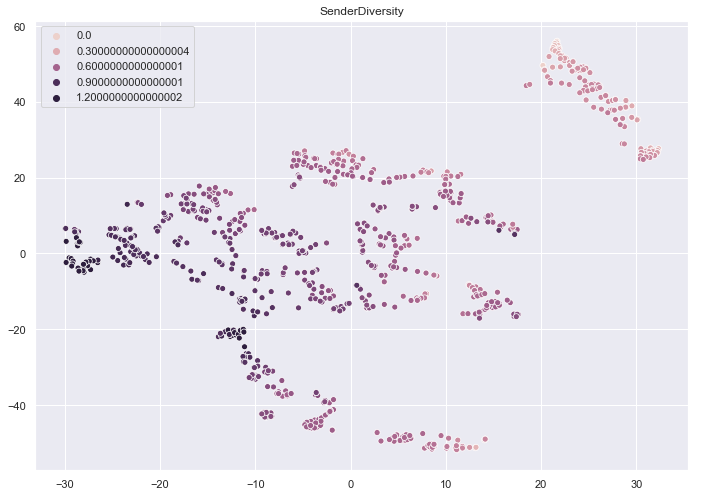

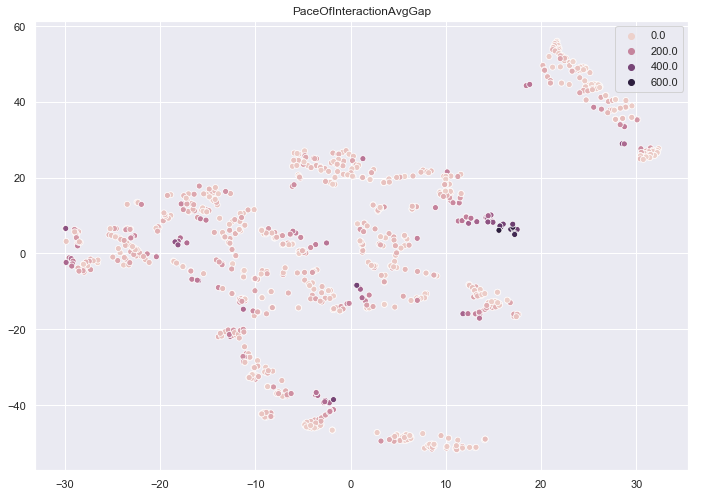

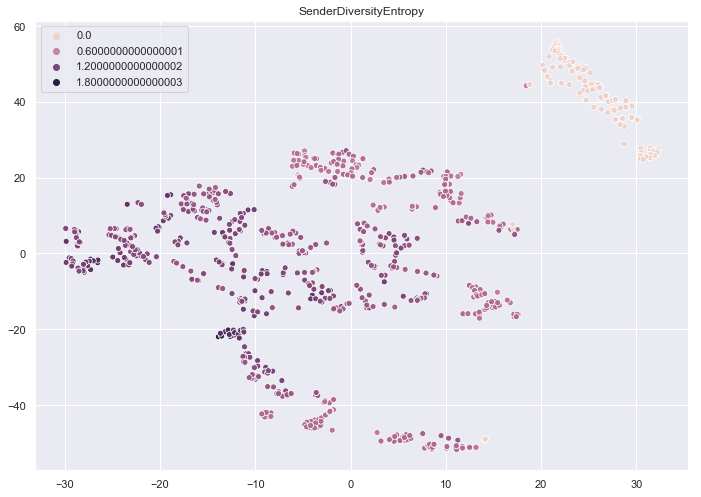

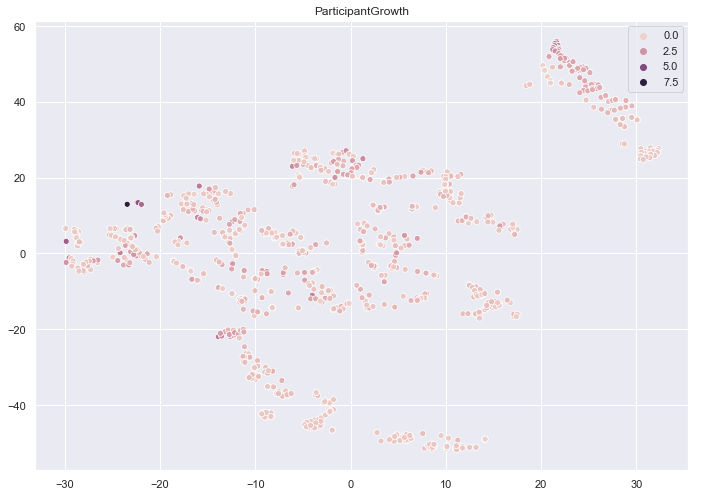

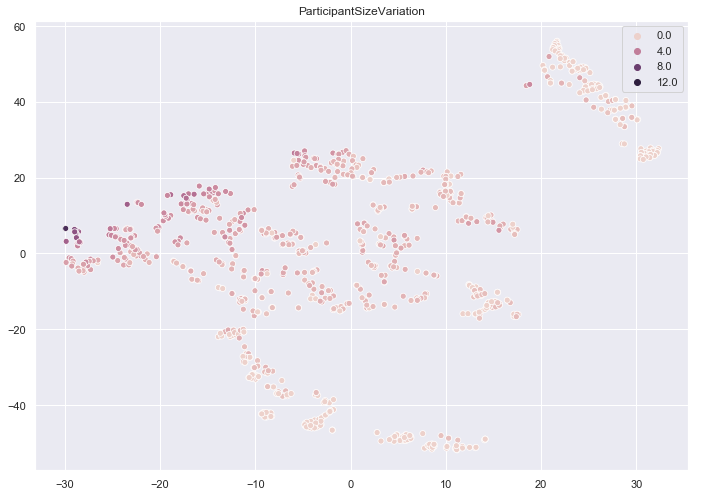

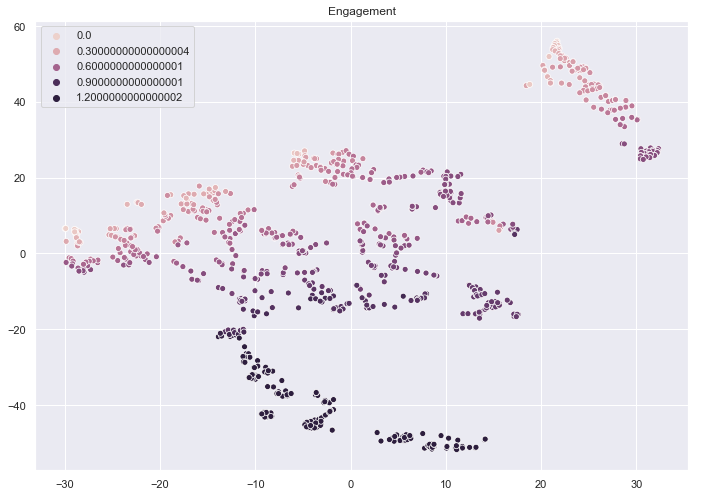

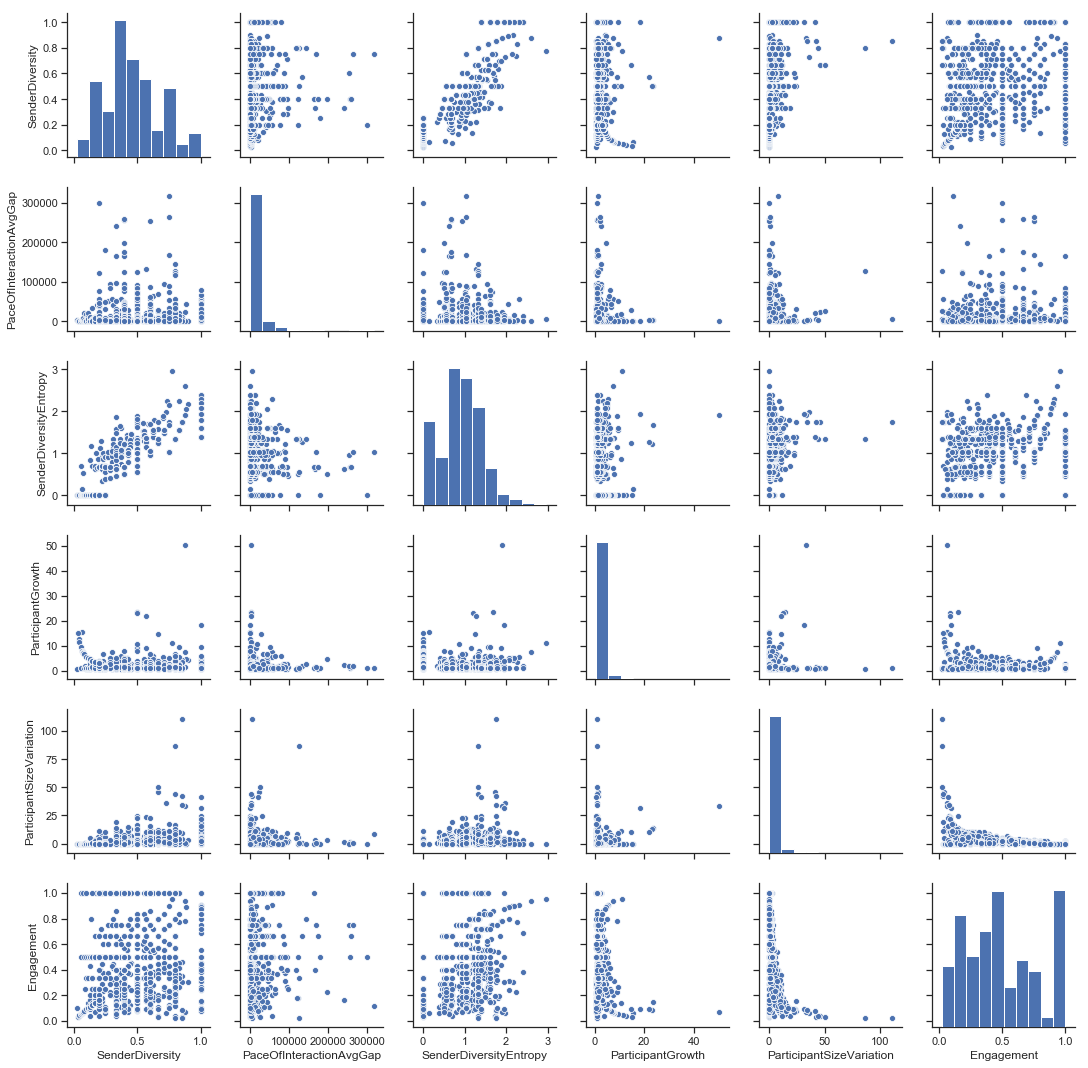

In [34]:
# Load the email data objects
inputFileName = "threads-1000"
fileExtension = ".json"
#print(inputFileName + fileExtension)
threadObjects = pd.read_json(inputFileName + fileExtension)

threadObjects.head()
givenThreadMeasureNames = ["threadID"]
computedThreadMeasureNames = ["SenderDiversity", "PaceOfInteractionAvgGap", "SenderDiversityEntropy", "ParticipantGrowth", "ParticipantSizeVariation", "Engagement"]
proxies = estimateThredProxiesFromThreadCollection(threadObjects, computedThreadMeasureNames)

threadObjectsRevised = updateThreadObjectsWithMeasures(threadObjects, computedThreadMeasureNames, proxies)
#threadObjectsRevised = updateThreadObjectsWithMDSEmbeddingCoordinates(threadObjectsRevised, proxies)
threadObjectsRevised = updateThreadObjectsWithtSNEEmbeddingCoordinates(threadObjectsRevised, proxies)

#print(threadObjects.head())
#print("----------------------")
#print(threadObjectsRevised.head())
#threadObjectsRevised.to_json(inputFileName + "_revV2" + fileExtension, orient='records')

sns.set(style="ticks")

df = pd.DataFrame(data=proxies, columns=list(proxyToFunction))
sns.pairplot(df)
plt.show()
